In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [ ]:
thttps://github.com/fmpr/CrowdLayer/blob/master/demo-labelme-mturk.ipynb

In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
#revisar bien el orden de label_names
folder = "./LabelMe/"

### Load Data and preprocess

In [ ]:
#which X?? max could do overfitting


In [4]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [5]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [6]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [104]:
#generate conf matrix...

conf_matrix = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            conf_matrix[t,Z_train[i],y_obs[i,t]] +=1
    conf_matrix[t,:,:] = conf_matrix[t,:,:]/conf_matrix[t,:,:].sum(axis=-1,keepdims=True)#normalize
    #how to fill where she not annotate?? -- Rodrigues put random there (1/K)
conf_matrix

/home/fmena/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

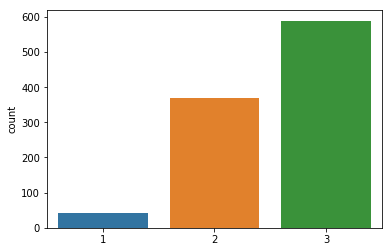

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


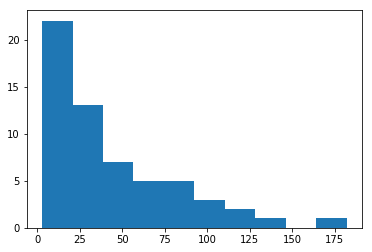

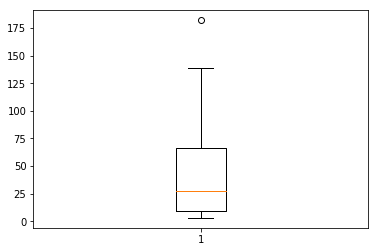

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [226]:
X_train_vgg16.shape

(1000, 512)

In [311]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Trained IDeal Model, Epochs to converge = 12


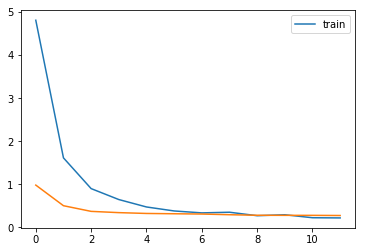

In [312]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

??

In [21]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.6143326308925
2 	 -2762.6462130736586 	0.0214	0.065072	0.026419
3 	 -2736.633205510148 	0.0117	0.059334	0.009416
4 	 -2725.3781176279813 	0.0071	0.058779	0.004113
5 	 -2719.6973770375794 	0.0041	0.051646	0.002084
6 	 -2716.5666539552362 	0.0027	0.040519	0.001151
7 	 -2714.7759730494768 	0.0021	0.031279	0.000659
8 	 -2713.6296344845814 	0.0017	0.024918	0.000422
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]


In [22]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [24]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [ ]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

In [ ]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

In [ ]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

### Raykar Model (joint predict model)

In [318]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [ ]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(10,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [319]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
#r_obs = set_representation(y_obs,"repeat")
r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


In [320]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [ ]:
M_seted = ??

In [ ]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro
gMixture_Global.lambda_random = True #revisar si efectivamente sirve o no
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [109]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [115]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global        0.99          0.99
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.923401      0.923401
====  ======  ==========  ============


In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))